# Fast tokenizers' special powers (PyTorch)

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]

In [17]:
from pprint import pprint

В этом разделе мы более подробно рассмотрим возможности токенизаторов в 🤗 Transformers. До сих пор мы использовали их только для токенизации входных данных или декодирования идентификаторов обратно в текст, но токенизаторы — особенно те, которые поддерживаются библиотекой 🤗 Tokenizers — могут делать гораздо больше. Чтобы проиллюстрировать эти дополнительные возможности, мы рассмотрим, как воспроизвести результаты токен-классификации (которую мы назвали ner) и вопросно-ответных конвейеров, с которыми мы впервые столкнулись в Главе 1.

Медленные токенизаторы — это те, которые написаны на Python внутри библиотеки 🤗 Transformers, в то время как быстрые версии — это те, которые предоставляются 🤗 Tokenizers, которые написаны на Rust.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


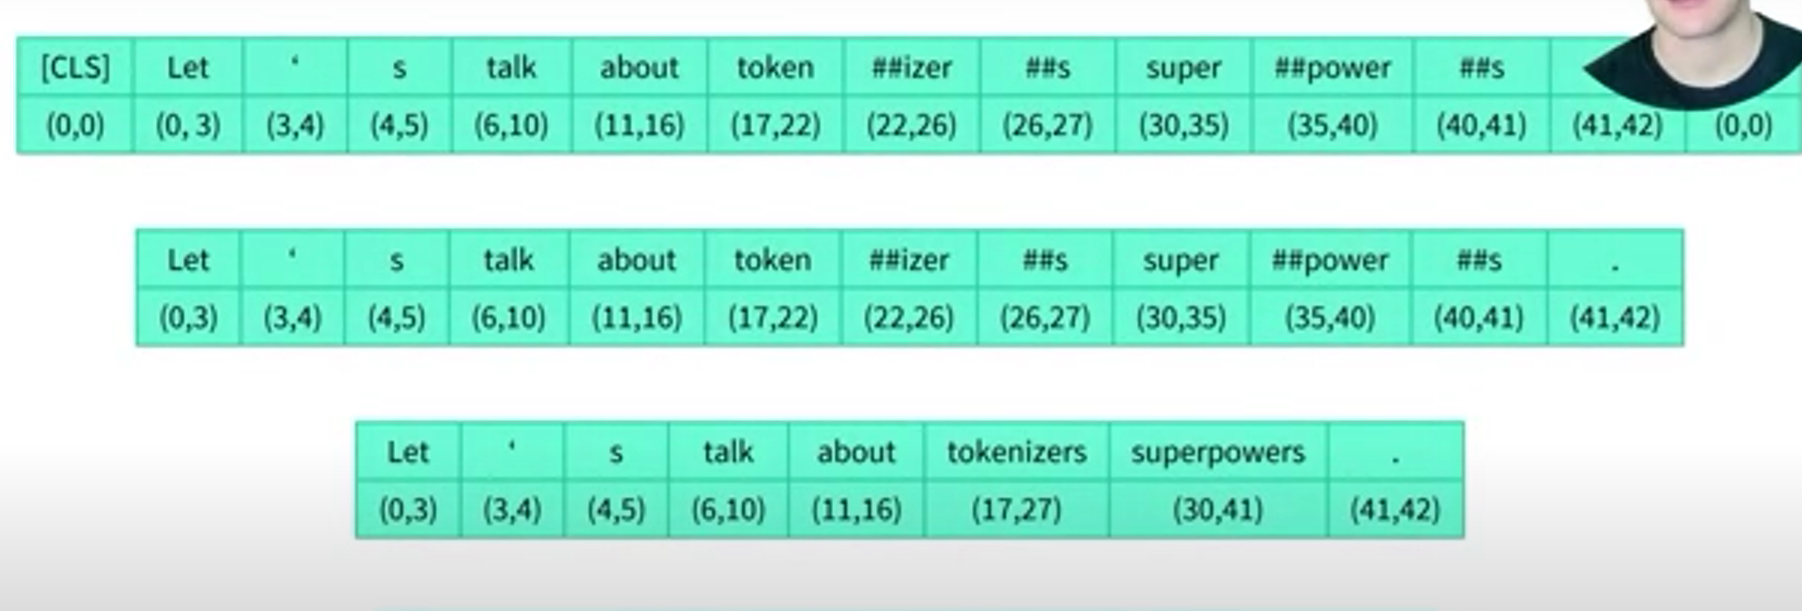

In [3]:
file_path = "/content/drive/My Drive/Hugging_face/tokenaze.png"

from IPython.display import display
from PIL import Image

# Открываем и отображаем изображение
img = Image.open(file_path)  # Укажите путь к файлу
display(img)

Вывод токенизатора — это не простой словарь Python; на самом деле мы получаем специальный объект BatchEncoding. Это подкласс словаря (именно поэтому мы могли индексировать этот результат без каких-либо проблем раньше), но с дополнительными методами, которые в основном используются быстрыми токенизаторами.

Помимо их возможностей параллелизации, ключевая функциональность быстрых токенизаторов заключается в том, что они всегда отслеживают исходный диапазон текстов, из которых берутся конечные токены — функция, которую мы называем отображением смещения. Это, в свою очередь, открывает такие функции, как отображение каждого слова на сгенерированные им токены или отображение каждого символа исходного текста на токен, внутри которого он находится, и наоборот.

Давайте рассмотрим пример:

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
encoding = tokenizer(example)
print(type(encoding))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

<class 'transformers.tokenization_utils_base.BatchEncoding'>


In [5]:
# We can either check the attribute is_fast of the tokenizer:
tokenizer.is_fast

True

In [6]:
# or check the same attribute of our encoding:
encoding.is_fast

True

Давайте посмотрим, что позволяет нам делать быстрый токенизатор. Во-первых, мы можем получить доступ к токенам без необходимости конвертировать идентификаторы обратно в токены:

In [18]:
pprint(encoding.tokens())

['[CLS]',
 'My',
 'name',
 'is',
 'S',
 '##yl',
 '##va',
 '##in',
 'and',
 'I',
 'work',
 'at',
 'Hu',
 '##gging',
 'Face',
 'in',
 'Brooklyn',
 '.',
 '[SEP]']


В этом случае токен с индексом 5 — это ##yl, который является частью слова «Sylvain» в исходном предложении. Мы также можем использовать метод word_ids(), чтобы получить индекс слова, из которого происходит каждый токен:

In [8]:
encoding.word_ids()

[None, 0, 1, 2, 3, 3, 3, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, None]

<small>Мы видим, что специальные токены токенизатора [CLS] и [SEP] сопоставлены с None, а затем каждый токен сопоставлен со словом, из которого он происходит. Это особенно полезно для определения того, находится ли токен в начале слова или два токена находятся в одном слове. Для этого мы могли бы положиться на префикс ##, но он работает только для токенизаторов типа BERT; этот метод работает для любого типа токенизатора, если он быстрый. В следующей главе мы увидим, как можно использовать эту возможность для правильного применения меток, которые у нас есть для каждого слова, к токенам в таких задачах, как распознавание именованных сущностей (NER) и разметка частей речи (POS). Мы также можем использовать его для маскировки всех токенов, происходящих от одного и того же слова, в моделировании языка с масками (метод, называемый маскировкой целых слов).</small>

<small>Аналогично, есть метод sentence_ids(), который мы можем использовать для сопоставления токена с предложением, из которого он пришел (хотя в этом случае token_type_ids, возвращаемый токенизатором, может дать нам ту же информацию).

Наконец, мы можем сопоставить любое слово или токен с символами в исходном тексте и наоборот с помощью методов word_to_chars() или token_to_chars() и char_to_word() или char_to_token(). Например, метод word_ids() сообщил нам, что ##yl является частью слова в индексе 3, но какое это слово в предложении? Мы можем узнать это так:</small>

In [15]:
start, end = encoding.word_to_chars(3)
start # 11
# end # 18
example[start:end] # example - специальное слово

'Sylvain'

Как мы уже упоминали ранее, все это работает на основе того факта, что быстрый токенизатор отслеживает диапазон текста, из которого поступает каждый токен в списке смещений. Чтобы проиллюстрировать их использование, далее мы покажем вам, как вручную воспроизвести результаты конвейера классификации токенов.

In [19]:
from transformers import pipeline

token_classifier = pipeline("token-classification")
resalt = token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")
pprint(resalt)

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision 4c53496 (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


[{'end': 12,
  'entity': 'I-PER',
  'index': 4,
  'score': 0.99938285,
  'start': 11,
  'word': 'S'},
 {'end': 14,
  'entity': 'I-PER',
  'index': 5,
  'score': 0.99815494,
  'start': 12,
  'word': '##yl'},
 {'end': 16,
  'entity': 'I-PER',
  'index': 6,
  'score': 0.99590707,
  'start': 14,
  'word': '##va'},
 {'end': 18,
  'entity': 'I-PER',
  'index': 7,
  'score': 0.99923277,
  'start': 16,
  'word': '##in'},
 {'end': 35,
  'entity': 'I-ORG',
  'index': 12,
  'score': 0.9738931,
  'start': 33,
  'word': 'Hu'},
 {'end': 40,
  'entity': 'I-ORG',
  'index': 13,
  'score': 0.976115,
  'start': 35,
  'word': '##gging'},
 {'end': 45,
  'entity': 'I-ORG',
  'index': 14,
  'score': 0.9887976,
  'start': 41,
  'word': 'Face'},
 {'end': 57,
  'entity': 'I-LOC',
  'index': 16,
  'score': 0.9932106,
  'start': 49,
  'word': 'Brooklyn'}]


✏️ Попробуйте! Создайте свой собственный пример текста и посмотрите, сможете ли вы понять, какие токены связаны с идентификатором слова, а также как извлечь диапазоны символов для одного слова. Для получения бонусных баллов попробуйте использовать два предложения в качестве входных данных и посмотрите, имеют ли для вас смысл идентификаторы предложений.

## Внутри конвейера классификации токенов


В Главе 1 мы впервые попробовали применить NER — где задача состоит в том, чтобы определить, какие части текста соответствуют сущностям, таким как лица, местоположения или организации — с помощью функции 🤗 Transformers pipeline(). Затем, в Главе 2, мы увидели, как конвейер группирует три этапа, необходимые для получения прогнозов из необработанного текста: токенизация, передача входных данных через модель и постобработка. Первые два шага в конвейере классификации токенов такие же, как и в любом другом конвейере, но постобработка немного сложнее — давайте посмотрим, как!

Получение базовых результатов с помощью конвейера
Сначала давайте возьмем конвейер классификации токенов, чтобы мы могли получить некоторые результаты для сравнения вручную. Модель, используемая по умолчанию, — dbmdz/bert-large-cased-finetuned-conll03-english; она выполняет NER для предложений:

In [21]:
from transformers import pipeline

token_classifier = pipeline("token-classification")
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision 4c53496 (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


[{'entity': 'I-PER',
  'score': 0.99938285,
  'index': 4,
  'word': 'S',
  'start': 11,
  'end': 12},
 {'entity': 'I-PER',
  'score': 0.99815494,
  'index': 5,
  'word': '##yl',
  'start': 12,
  'end': 14},
 {'entity': 'I-PER',
  'score': 0.99590707,
  'index': 6,
  'word': '##va',
  'start': 14,
  'end': 16},
 {'entity': 'I-PER',
  'score': 0.99923277,
  'index': 7,
  'word': '##in',
  'start': 16,
  'end': 18},
 {'entity': 'I-ORG',
  'score': 0.9738931,
  'index': 12,
  'word': 'Hu',
  'start': 33,
  'end': 35},
 {'entity': 'I-ORG',
  'score': 0.976115,
  'index': 13,
  'word': '##gging',
  'start': 35,
  'end': 40},
 {'entity': 'I-ORG',
  'score': 0.9887976,
  'index': 14,
  'word': 'Face',
  'start': 41,
  'end': 45},
 {'entity': 'I-LOC',
  'score': 0.9932106,
  'index': 16,
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

In [22]:
token_classifier = pipeline("token-classification", aggregation_strategy="simple")
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision 4c53496 (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


[{'entity_group': 'PER',
  'score': 0.9981694,
  'word': 'Sylvain',
  'start': 11,
  'end': 18},
 {'entity_group': 'ORG',
  'score': 0.9796019,
  'word': 'Hugging Face',
  'start': 33,
  'end': 45},
 {'entity_group': 'LOC',
  'score': 0.9932106,
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

Выбранная aggregation_strategy изменит оценки, вычисленные для каждой сгруппированной сущности. При «`simple`» оценка — это просто среднее значение оценок каждого токена в данной сущности: например, оценка «Sylvain» — это среднее значение оценок, которые мы видели в предыдущем примере для токенов S, ##yl, ##va и ##in. Другие доступные стратегии:  

`"first"`, где оценка каждой сущности является оценкой первого токена этой сущности (так, для "Sylvain" это будет 0,993828, оценка токена S)  
`"max"`, где оценка каждой сущности является максимальной оценкой токенов в этой сущности (так, для "Hugging Face" это будет 0,98879766, оценка "Face")  
`"average"`, где оценка каждой сущности является средним значением оценок слов, составляющих эту сущность (так, для "Sylvain" не будет никакой разницы с "simple" стратегией, но "Hugging Face" будет иметь оценку 0,9819, среднюю оценку "Hugging", 0,975, и "Face", 0,98879)  
Теперь давайте посмотрим, как получить эти результаты без использования функции pipeline()!

## From inputs to predictions

Сначала нам нужно токенизировать наш ввод и передать его через модель. Это делается точно так же, как в Главе 2; мы создаем экземпляр токенизатора и модели с помощью классов AutoXxx, а затем используем их в нашем примере:

In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

model_checkpoint = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
inputs = tokenizer(example, return_tensors="pt")
outputs = model(**inputs)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Поскольку здесь мы используем AutoModelForTokenClassification, мы получаем один набор логитов для каждого токена во входной последовательности:

In [2]:
print(inputs["input_ids"].shape)
print(outputs.logits.shape)

torch.Size([1, 19])
torch.Size([1, 19, 9])


У нас есть пакет с 1 последовательностью из 19 токенов, а модель имеет 9 различных меток, поэтому выходные данные модели имеют форму 1 x 19 x 9. Как и в случае с конвейером классификации текста, мы используем функцию softmax для преобразования этих логитов в вероятности и берем argmax для получения прогнозов (обратите внимание, что мы можем взять argmax для логитов, поскольку softmax не меняет порядок):

In [3]:
import torch

probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)[0].tolist()
predictions = outputs.logits.argmax(dim=-1)[0].tolist()
print(predictions)

[0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 6, 6, 6, 0, 8, 0, 0]


Атрибут model.config.id2label содержит сопоставление индексов с метками, которые мы можем использовать для осмысления прогнозов:

In [4]:
model.config.id2label

{0: 'O',
 1: 'B-MISC',
 2: 'I-MISC',
 3: 'B-PER',
 4: 'I-PER',
 5: 'B-ORG',
 6: 'I-ORG',
 7: 'B-LOC',
 8: 'I-LOC'}

Как мы видели ранее, есть 9 меток: O — метка для токенов, которые не находятся ни в одной именованной сущности (она означает «вне»), и затем у нас есть две метки для каждого типа сущности (разное, персона, организация и местоположение - (miscellaneous, person, organization, and location)). Метка B-XXX указывает, что токен находится в начале сущности XXX, а метка I-XXX указывает, что токен находится внутри сущности XXX. Например, в текущем примере мы ожидаем, что наша модель классифицирует токен S как B-PER (начало сущности человека), а токены ##yl, ##va и ##in как I-PER (внутри сущности человека).

Вы можете подумать, что модель была неправа в этом случае, поскольку она дала метку I-PER всем четырем этим токенам, но это не совсем так. На самом деле существует два формата для этих меток B- и I-: IOB1 и IOB2. Формат IOB2 (ниже розовым) — это тот, который мы ввели, тогда как в формате IOB1 (синим) метки, начинающиеся с B-, используются только для разделения двух смежных сущностей одного типа. Модель, которую мы используем, была точно настроена на наборе данных с использованием этого формата, поэтому она назначает метку I-PER токену S.

С помощью этой карты мы готовы воспроизвести (почти полностью) результаты первого конвейера — мы можем просто взять оценку и метку каждого токена, который не был классифицирован как O:

In [5]:
results = []
tokens = inputs.tokens()

for idx, pred in enumerate(predictions):
    label = model.config.id2label[pred]
    if label != "O":
        results.append(
            {"entity": label, "score": probabilities[idx][pred], "word": tokens[idx]}
        )

print(results)

[{'entity': 'I-PER', 'score': 0.9993828535079956, 'word': 'S'}, {'entity': 'I-PER', 'score': 0.9981548190116882, 'word': '##yl'}, {'entity': 'I-PER', 'score': 0.995907187461853, 'word': '##va'}, {'entity': 'I-PER', 'score': 0.9992327690124512, 'word': '##in'}, {'entity': 'I-ORG', 'score': 0.9738931059837341, 'word': 'Hu'}, {'entity': 'I-ORG', 'score': 0.9761149883270264, 'word': '##gging'}, {'entity': 'I-ORG', 'score': 0.9887974858283997, 'word': 'Face'}, {'entity': 'I-LOC', 'score': 0.99321049451828, 'word': 'Brooklyn'}]


Это очень похоже на то, что у нас было раньше, за одним исключением: конвейер также предоставил нам информацию о начале и конце каждой сущности в исходном предложении. Вот где в игру вступит наше отображение смещения. Чтобы получить смещения, нам просто нужно установить return_offsets_mapping=True, когда мы применяем токенизатор к нашим входам:

In [6]:
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
inputs_with_offsets["offset_mapping"]

[(0, 0),
 (0, 2),
 (3, 7),
 (8, 10),
 (11, 12),
 (12, 14),
 (14, 16),
 (16, 18),
 (19, 22),
 (23, 24),
 (25, 29),
 (30, 32),
 (33, 35),
 (35, 40),
 (41, 45),
 (46, 48),
 (49, 57),
 (57, 58),
 (0, 0)]

Каждый кортеж — это промежуток текста, соответствующий каждому токену, где (0, 0) зарезервировано для специальных токенов. Ранее мы видели, что токен с индексом 5 — это ##yl, который имеет здесь смещения (12, 14). Если мы возьмем соответствующий срез в нашем примере:

In [7]:
example[12:14]

'yl'

Using this, we can now complete the previous results:

In [8]:
results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

for idx, pred in enumerate(predictions):
    label = model.config.id2label[pred]
    if label != "O":
        start, end = offsets[idx]
        results.append(
            {
                "entity": label,
                "score": probabilities[idx][pred],
                "word": tokens[idx],
                "start": start,
                "end": end,
            }
        )

print(results)

[{'entity': 'I-PER', 'score': 0.9993828535079956, 'word': 'S', 'start': 11, 'end': 12}, {'entity': 'I-PER', 'score': 0.9981548190116882, 'word': '##yl', 'start': 12, 'end': 14}, {'entity': 'I-PER', 'score': 0.995907187461853, 'word': '##va', 'start': 14, 'end': 16}, {'entity': 'I-PER', 'score': 0.9992327690124512, 'word': '##in', 'start': 16, 'end': 18}, {'entity': 'I-ORG', 'score': 0.9738931059837341, 'word': 'Hu', 'start': 33, 'end': 35}, {'entity': 'I-ORG', 'score': 0.9761149883270264, 'word': '##gging', 'start': 35, 'end': 40}, {'entity': 'I-ORG', 'score': 0.9887974858283997, 'word': 'Face', 'start': 41, 'end': 45}, {'entity': 'I-LOC', 'score': 0.99321049451828, 'word': 'Brooklyn', 'start': 49, 'end': 57}]


Это то же самое, что мы получили из первого pipeline!

## Группировка сущностей

Использование смещений для определения начальных и конечных ключей для каждой сущности удобно, но эта информация не является строго необходимой. Однако, когда мы хотим сгруппировать сущности вместе, смещения сэкономят нам много запутанного кода. Например, если мы хотим сгруппировать токены Hu, ##gging и Face, мы могли бы создать специальные правила, которые говорят, что первые два должны быть присоединены при удалении ##, а Face должен быть добавлен с пробелом, поскольку он не начинается с ## — но это будет работать только для этого конкретного типа токенизатора. Нам пришлось бы написать другой набор правил для токенизатора SentencePiece или Byte-Pair-Encoding (обсуждается далее в этой главе).

Со смещениями весь этот пользовательский код уходит: мы просто можем взять промежуток в исходном тексте, который начинается с первого токена и заканчивается последним токеном. Таким образом, в случае токенов Hu, ##gging и Face мы должны начать с символа 33 (начало Hu) и закончить перед символом 45 (конец Face):

In [10]:
example[33:45]

'Hugging Face'

Чтобы написать код, который выполняет постобработку прогнозов при группировке сущностей, мы сгруппируем сущности, которые являются последовательными и помечены как I-XXX, за исключением первой, которая может быть помечена как B-XXX или I-XXX (таким образом, мы прекращаем группировать сущность, когда получаем O, новый тип сущности, или B-XXX, который говорит нам, что начинается сущность того же типа):

In [11]:
import numpy as np

results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

idx = 0
while idx < len(predictions):
    pred = predictions[idx]
    label = model.config.id2label[pred]
    if label != "O":
        # Remove the B- or I-
        label = label[2:]
        start, _ = offsets[idx]

        # Grab all the tokens labeled with I-label
        all_scores = []
        while (
            idx < len(predictions)
            and model.config.id2label[predictions[idx]] == f"I-{label}"
        ):
            all_scores.append(probabilities[idx][pred])
            _, end = offsets[idx]
            idx += 1

        # The score is the mean of all the scores of the tokens in that grouped entity
        score = np.mean(all_scores).item()
        word = example[start:end]
        results.append(
            {
                "entity_group": label,
                "score": score,
                "word": word,
                "start": start,
                "end": end,
            }
        )
    idx += 1

print(results)

[{'entity_group': 'PER', 'score': 0.998169407248497, 'word': 'Sylvain', 'start': 11, 'end': 18}, {'entity_group': 'ORG', 'score': 0.9796018600463867, 'word': 'Hugging Face', 'start': 33, 'end': 45}, {'entity_group': 'LOC', 'score': 0.99321049451828, 'word': 'Brooklyn', 'start': 49, 'end': 57}]


And we get the same results as with our second pipeline!

Другим примером задачи, где эти смещения чрезвычайно полезны, является ответ на вопрос. Погружение в этот конвейер, которое мы сделаем в следующем разделе, также позволит нам взглянуть на одну последнюю функцию токенизаторов в библиотеке 🤗 Transformers: работа с переполнением токенов, когда мы усекаем входные данные до заданной длины.